In this notebook, we test out hyperparameter tuning with Optuna. again. with GNBlocks and only 5 edges per node. Also we restrict the range of possible parameter values to more closely match GNBLock_baseline because we know we got not-insane results from there. 

similar to sandbox 8 but with larger dataset and slightly tweaked param ranges.

In [3]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
import ml_collections
import optuna 
from functools import partial
from datetime import datetime
import os 

In [5]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### set up functions for optuna

In [6]:
CHECKPOINT_PATH = "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/experiments/tuning"

In [7]:
def objective(trial, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    # Optimizer.
    config.optimizer = "adam"
    # config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, 
                                               log=True)
    # if config.optimizer == "sgd":
    #     config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Data params that are used in training 
    config.output_steps = 4

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 200
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPBlock'
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.6)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later

    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 8), # range 2 - 512
        2**trial.suggest_int("node_mlp_2_power", 1, 8), # range 2 - 512
        2) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, "checkpoints", str(datetime.now()))

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets)
    
    # retrieve and return val loss (MSE)
    print("eval_metrics_dict['val'].loss", eval_metrics_dict['val'].loss)
    print()
    return eval_metrics_dict['val'].loss.total / eval_metrics_dict['val'].loss.count




In [8]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

In [9]:
def prepare_study(study_name):
    # generate dataset 
    dataset_config = get_data_config()
    datasets = create_dataset(dataset_config)
    print_graph_fts(datasets['train']['inputs'][0][0])

    # get the objective function that reuses the pre-generated datasets 
    objective_with_dataset = partial(objective, datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    # study.optimize(objective_with_dataset, 
    #                n_trials=25-len(study.trials), 
    #                n_jobs=1)
    
    return study, objective_with_dataset

### try hyperparameter tuning again with fewer params and lower learning rate options

In [10]:
# get study
study9, objective_with_dataset = prepare_study(study_name="hparam_study_9")

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


[I 2023-12-01 11:54:11,644] A new study created in RDB with name: hparam_study_9


In [11]:
study9.optimize(objective_with_dataset, 
                n_trials=5-len(study9.trials), 
                n_jobs=1)

eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1855.3488, dtype=float32), count=Array(2000., dtype=float32))



[I 2023-12-01 13:56:39,952] Trial 0 finished with value: 0.9276743531227112 and parameters: {'learning_rate': 0.01629831800734565, 'dropout_rate': 0.15850938251544924, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 5}. Best is trial 0 with value: 0.9276743531227112.
[I 2023-12-01 14:34:02,684] Trial 1 finished with value: 0.9276743531227112 and parameters: {'learning_rate': 0.003194829758316371, 'dropout_rate': 0.4363097779345831, 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 7}. Best is trial 0 with value: 0.9276743531227112.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1855.3488, dtype=float32), count=Array(2000., dtype=float32))



[I 2023-12-01 14:53:58,279] Trial 2 finished with value: 0.9276743531227112 and parameters: {'learning_rate': 0.006524485843675054, 'dropout_rate': 0.4780653228461452, 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 3, 'node_mlp_2_power': 1}. Best is trial 0 with value: 0.9276743531227112.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1855.3488, dtype=float32), count=Array(2000., dtype=float32))



[I 2023-12-01 15:20:44,945] Trial 3 finished with value: 0.9276743531227112 and parameters: {'learning_rate': 0.0027924696667982066, 'dropout_rate': 0.43382262585206977, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 3, 'node_mlp_2_power': 6}. Best is trial 0 with value: 0.9276743531227112.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1855.3488, dtype=float32), count=Array(2000., dtype=float32))



[I 2023-12-01 15:40:40,892] Trial 4 finished with value: 0.9157494902610779 and parameters: {'learning_rate': 0.00013240808625391743, 'dropout_rate': 0.590911527697419, 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 3, 'node_mlp_2_power': 3}. Best is trial 4 with value: 0.9157494902610779.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1831.499, dtype=float32), count=Array(2000., dtype=float32))



still i dont understand how some trials can end up with literally the exact same validation error to like 10 decimal places. 

In [12]:
study9.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9276743531227112], datetime_start=datetime.datetime(2023, 12, 1, 11, 54, 11, 847179), datetime_complete=datetime.datetime(2023, 12, 1, 13, 56, 39, 877314), params={'learning_rate': 0.01629831800734565, 'dropout_rate': 0.15850938251544924, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=1), 'edge_mlp_2_power': IntDistribution(high=3, log=False, low=1, step=1), 'node_mlp_1_power': IntDistribution(high=8, log=False, low=1, step=1), 'node_mlp_2_power': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=1, value=None),
 FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.92767435312

ok let's try visualizing this to see what in the hell is going wrong

In [13]:
fig = optuna.visualization.plot_intermediate_values(study9)
fig.show()

[W 2023-12-01 15:40:42,062] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [14]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study9, params=['learning_rate', 'dropout_rate'])
fig.show()

In [15]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study9, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [16]:
study9.optimize(objective_with_dataset, 
                n_trials=50-len(study9.trials), 
                n_jobs=1)

[I 2023-12-01 16:17:58,372] Trial 5 finished with value: 0.9276743531227112 and parameters: {'learning_rate': 0.0005326723165650542, 'dropout_rate': 0.5170576995243402, 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 1, 'node_mlp_2_power': 8}. Best is trial 4 with value: 0.9157494902610779.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1855.3488, dtype=float32), count=Array(2000., dtype=float32))



[I 2023-12-01 16:33:24,115] Trial 6 finished with value: 0.8848406076431274 and parameters: {'learning_rate': 0.0013708600989018886, 'dropout_rate': 0.43517494588286953, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 4, 'node_mlp_2_power': 4}. Best is trial 6 with value: 0.8848406076431274.


eval_metrics_dict['val'].loss Metric.from_output.<locals>.FromOutput(total=Array(1769.6813, dtype=float32), count=Array(2000., dtype=float32))



[W 2023-12-01 16:44:34,277] Trial 7 failed with parameters: {'learning_rate': 0.0022603175872847386, 'dropout_rate': 0.15147176911710183, 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 6, 'node_mlp_2_power': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/py/716jgpq538x2wf_s8t__x9b80000gn/T/ipykernel_38671/3264376729.py", line 52, in objective
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/utils/jraph_training.py", line 459, in train_and_evaluate_with_data
    n_rollout_steps=n_rollout_steps,
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/

KeyboardInterrupt: 

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study9)
fig.show()

[W 2023-12-01 01:47:27,260] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [17]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study9, params=['learning_rate', 'dropout_rate'])
fig.show()

In [18]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study9, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [19]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study9, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [20]:
print(study9.direction)

StudyDirection.MINIMIZE


In [21]:
study9.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9276743531227112], datetime_start=datetime.datetime(2023, 12, 1, 11, 54, 11, 847179), datetime_complete=datetime.datetime(2023, 12, 1, 13, 56, 39, 877314), params={'learning_rate': 0.01629831800734565, 'dropout_rate': 0.15850938251544924, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=1), 'edge_mlp_2_power': IntDistribution(high=3, log=False, low=1, step=1), 'node_mlp_1_power': IntDistribution(high=8, log=False, low=1, step=1), 'node_mlp_2_power': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=1, value=None),
 FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.92767435312

### plot predictions

In [24]:
print(study9.best_trial)
print(study9.best_params)

FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.8848406076431274], datetime_start=datetime.datetime(2023, 12, 1, 16, 17, 58, 425679), datetime_complete=datetime.datetime(2023, 12, 1, 16, 33, 24, 91635), params={'learning_rate': 0.0013708600989018886, 'dropout_rate': 0.43517494588286953, 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 4, 'node_mlp_2_power': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=1), 'edge_mlp_2_power': IntDistribution(high=3, log=False, low=1, step=1), 'node_mlp_1_power': IntDistribution(high=8, log=False, low=1, step=1), 'node_mlp_2_power': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=7, value=None)
{'learning_rate': 0.0013708600989018886, 'dropout_rate': 0.4351749458828

In [28]:
dataset_config = get_data_config()
datasets = create_dataset(dataset_config)

In [35]:
best_trial_config = dataset_config

# Optimizer.
best_trial_config.optimizer = "adam"
# config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
best_trial_config.learning_rate = study9.best_params['learning_rate']

# if config.optimizer == "sgd":
#     config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

# Data params that are used in training 
best_trial_config.output_steps = 4

# Training hyperparameters.
best_trial_config.batch_size = 1 # variable currently not used
best_trial_config.epochs = 200
best_trial_config.log_every_epochs = 5
best_trial_config.eval_every_epochs = 5
best_trial_config.checkpoint_every_epochs = 10

# GNN hyperparameters.
best_trial_config.model = 'MLPBlock'
best_trial_config.dropout_rate = study9.best_params['dropout_rate']
best_trial_config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
best_trial_config.layer_norm = False # TODO perhaps we want to turn on later

# choose the hidden layer feature size using powers of 2 
best_trial_config.edge_features = (
    2**study9.best_params["edge_mlp_1_power"],
    2**study9.best_params["edge_mlp_2_power"],
)
best_trial_config.node_features = (
    2**study9.best_params["node_mlp_1_power"],
    2**study9.best_params["node_mlp_2_power"],
    2) 
# note the last feature size will be the number of features that the graph predicts
best_trial_config.global_features = None

In [36]:
print(study9.best_trial.datetime_start)

2023-12-01 16:17:58.425679


In [39]:
# find the workdir with checkpoints manually based on the start time
# we should make this more automatic
best_trial_workdir = "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/experiments/tuning/checkpoints/2023-12-01 16:17:58.513538"

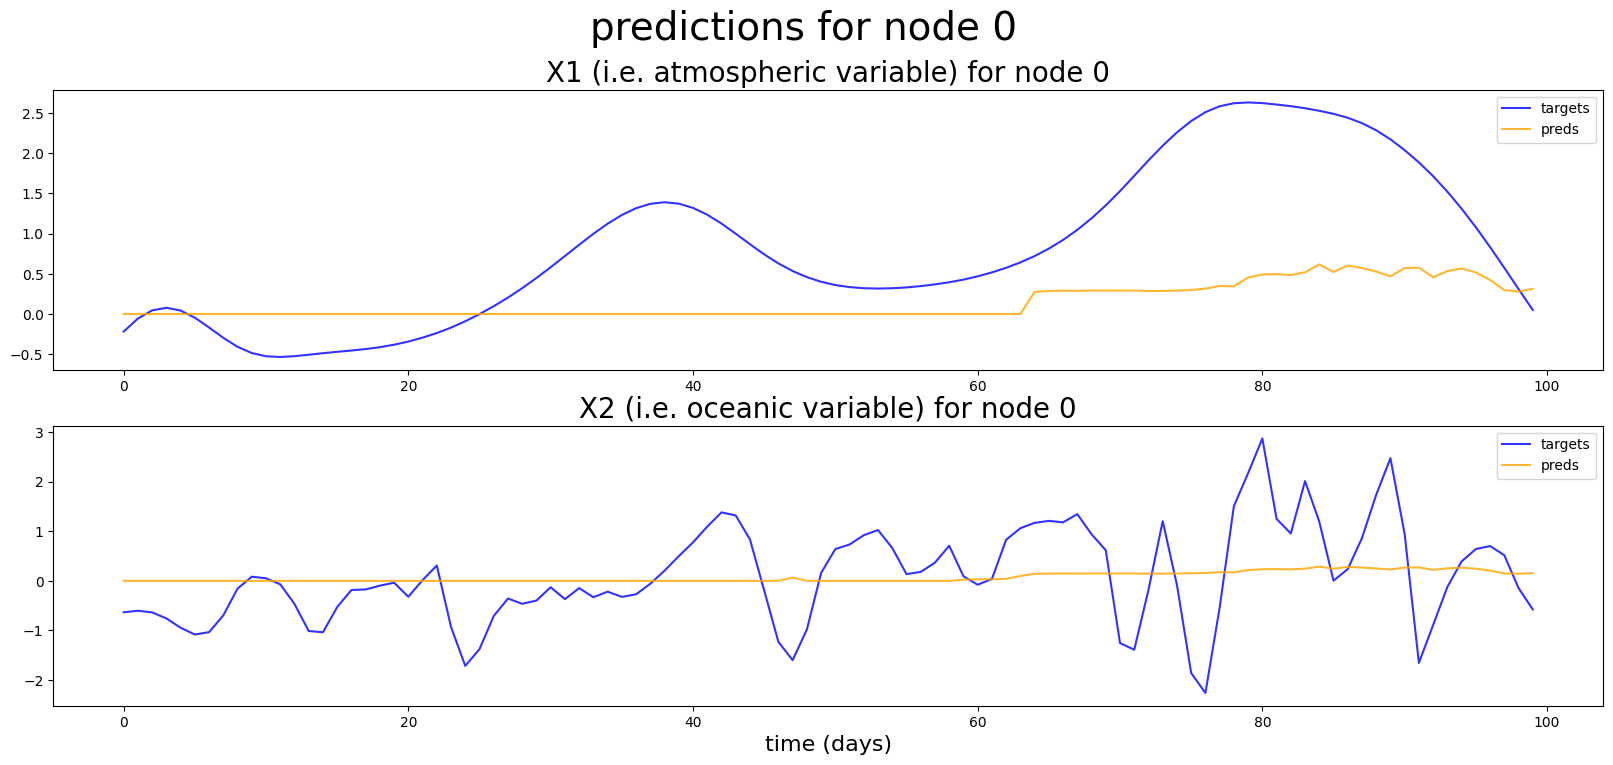

In [40]:
plot_predictions(
    config=best_trial_config,
    workdir=best_trial_workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

shit man why it is regressing to the mean again. and also seemingly unable to predict negative values. 

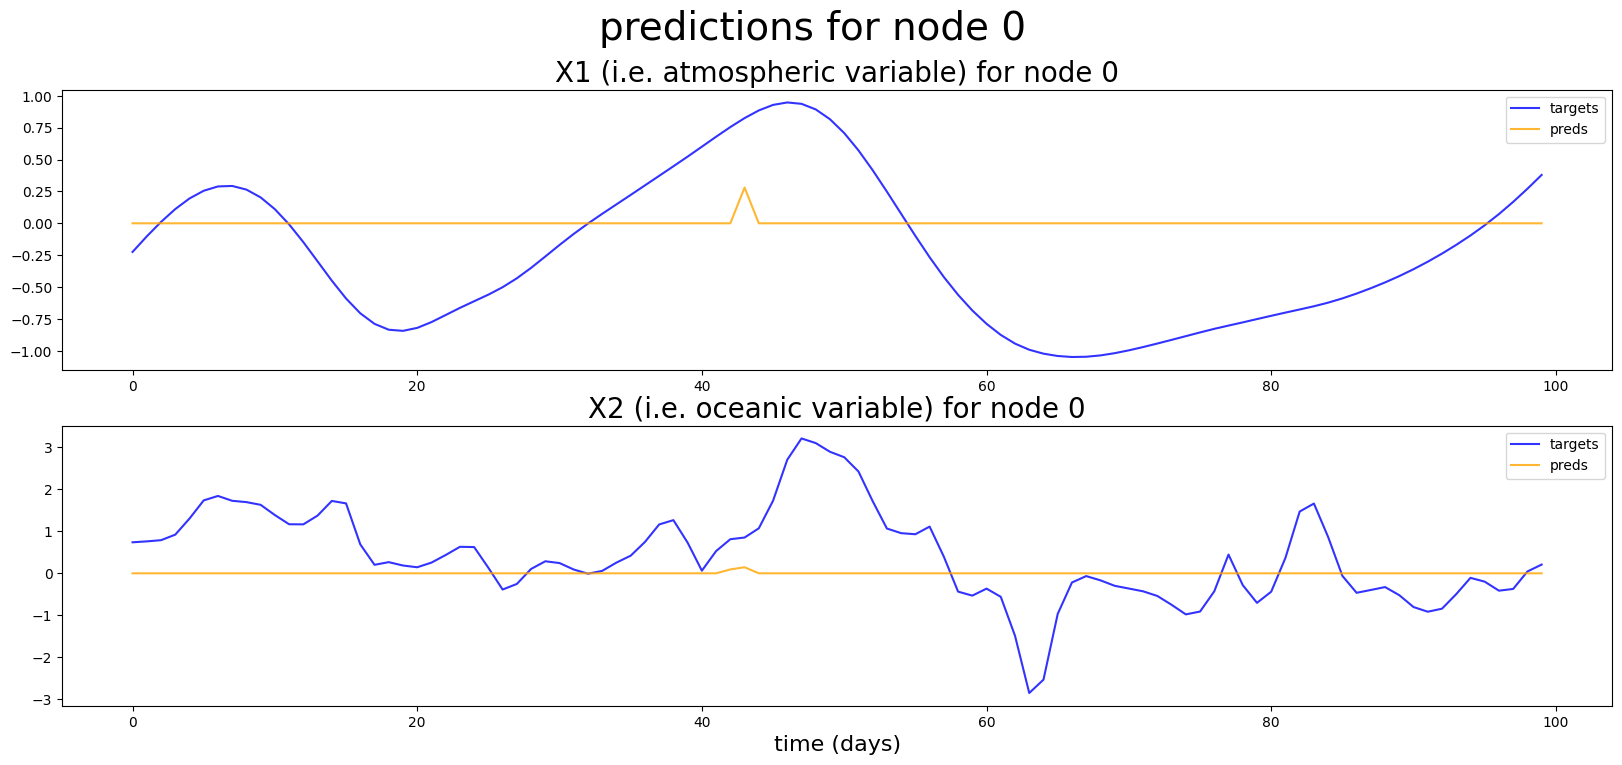

In [42]:
# plot train to see if the overfitting worked
plot_predictions(
    config=best_trial_config,
    workdir=best_trial_workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

wow. it couldn't even overfit on the training set....... 

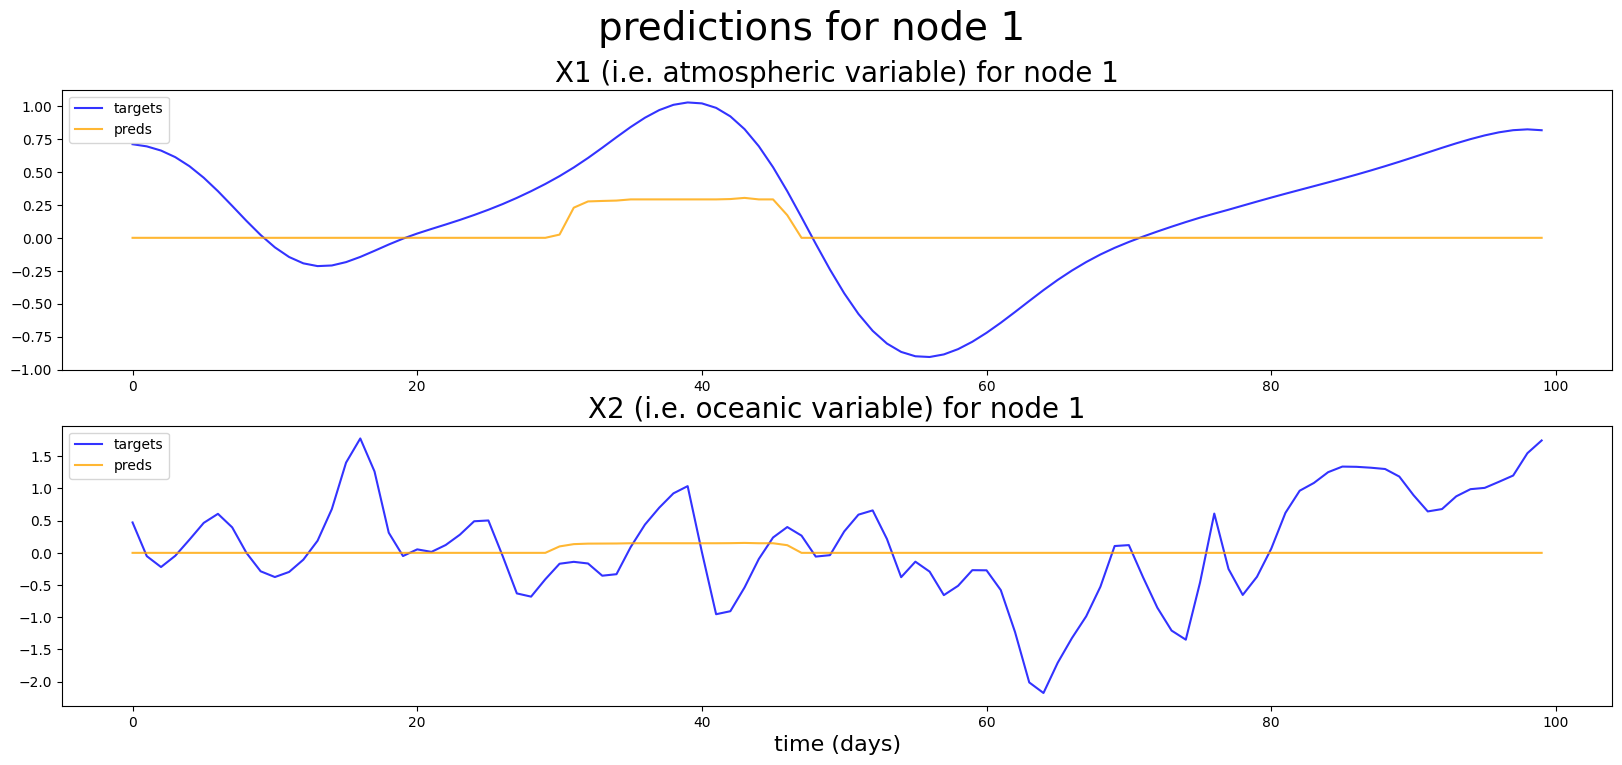

In [45]:
plot_predictions(
    config=best_trial_config,
    workdir=best_trial_workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=1, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

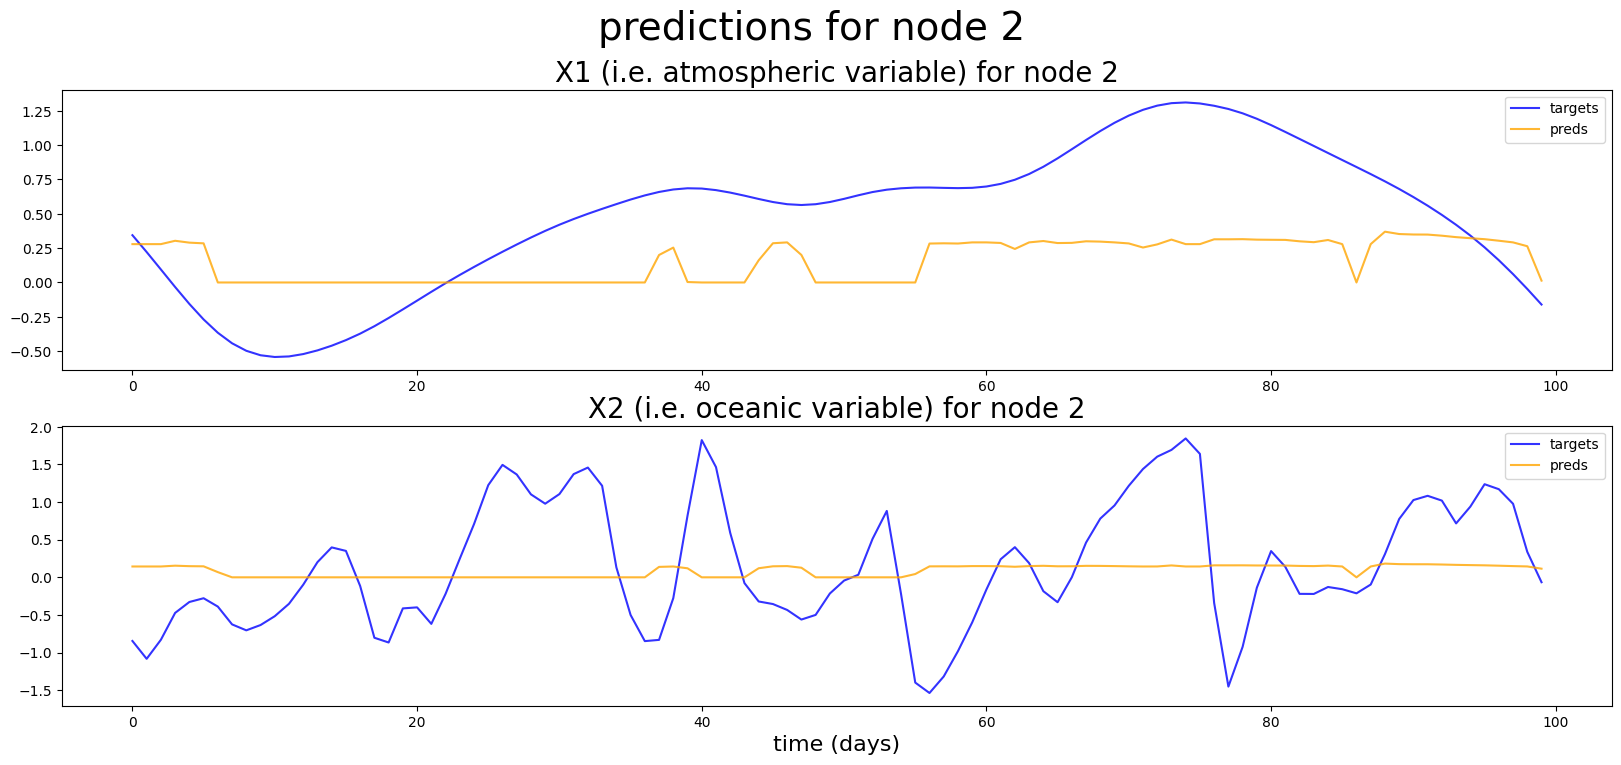

In [46]:
plot_predictions(
    config=best_trial_config,
    workdir=best_trial_workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=2, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

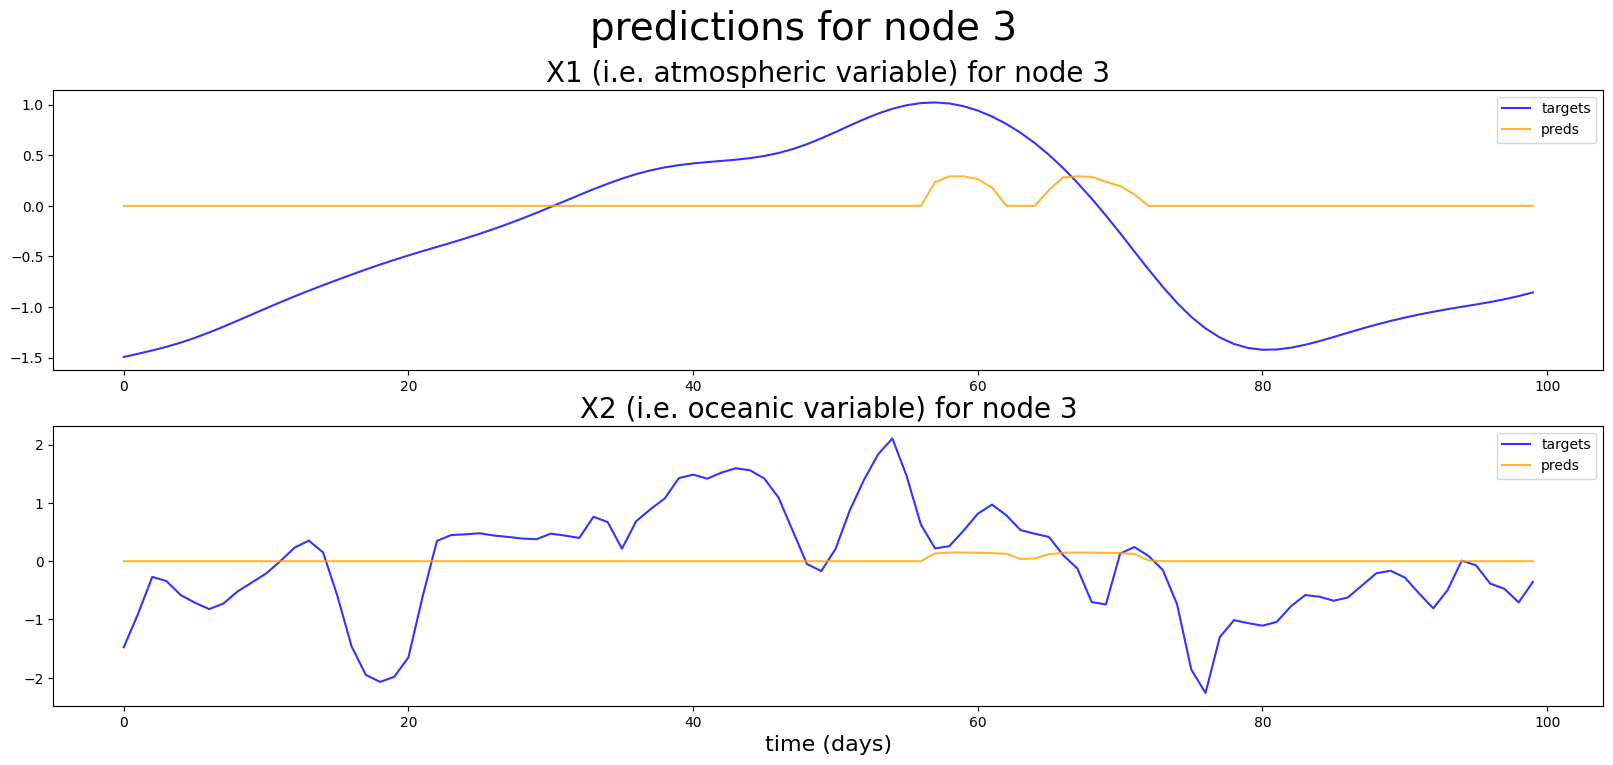

In [47]:
plot_predictions(
    config=best_trial_config,
    workdir=best_trial_workdir, # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=3, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)